# Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix



from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten, Input,MaxPool2D,Dropout,AveragePooling2D,concatenate,BatchNormalization,Activation, Add,GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


# preprocessing

In [3]:
data_directory = '/kaggle/input/teeth-dataset/Teeth_Dataset/'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Training",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Validation",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Testing",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

class_names = train_dataset.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))
print("Number of Batches:", len(train_dataset))

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class Names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of Classes: 7
Number of Batches: 97


In [4]:
def plot_class_distribution(dataset, title):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)
    
    for _, labels in dataset:
        for label in labels:
            class_counts[label] += 1
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title(f'Class Distribution in {title} Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

def display_sample_images(dataset, title, num_images=9):
    class_names = dataset.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(f'Sample Images from {title} Dataset')
    plt.show()


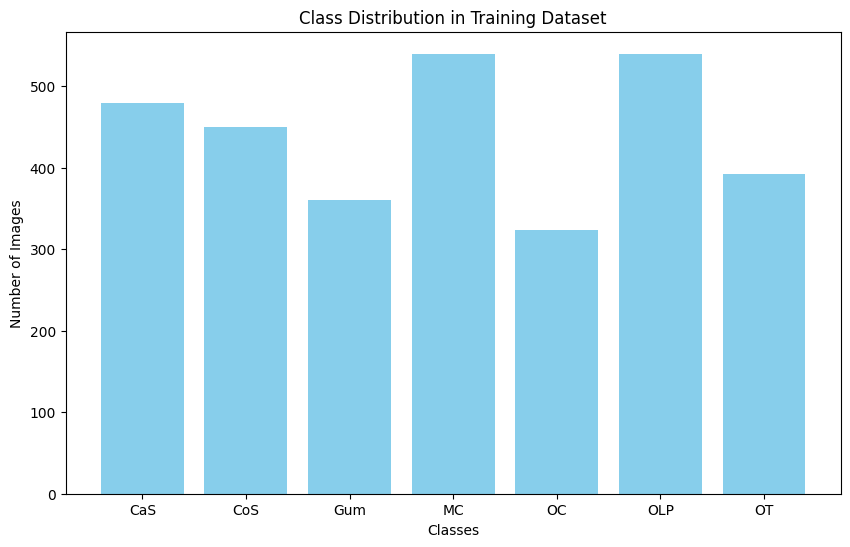

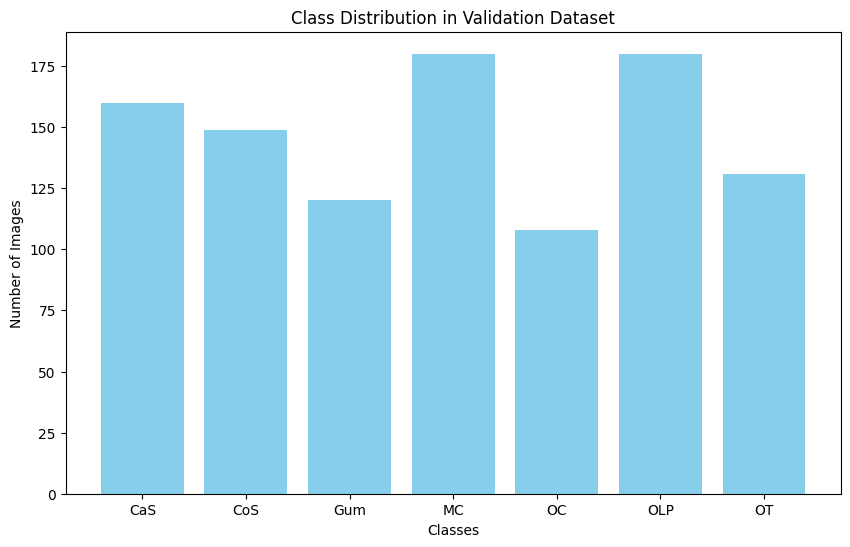

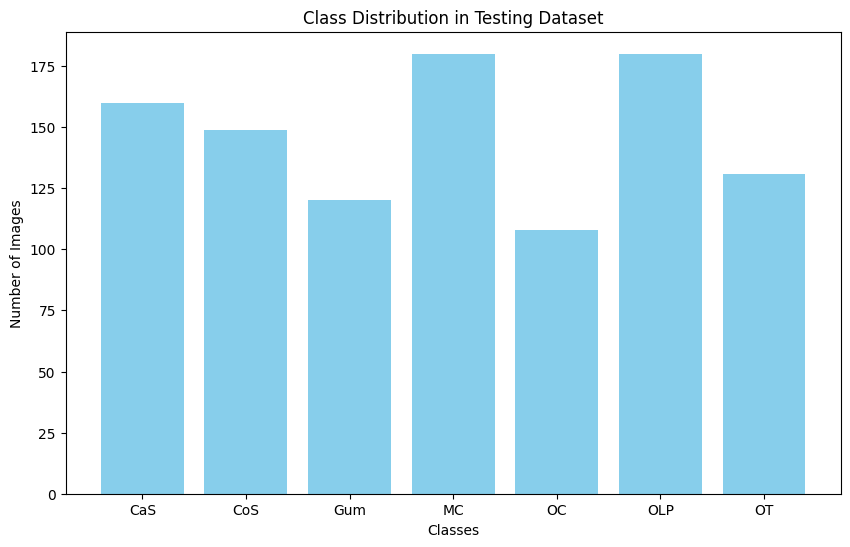

In [5]:
plot_class_distribution(train_dataset, "Training")
plot_class_distribution(validation_dataset, "Validation")
plot_class_distribution(test_dataset, "Testing")

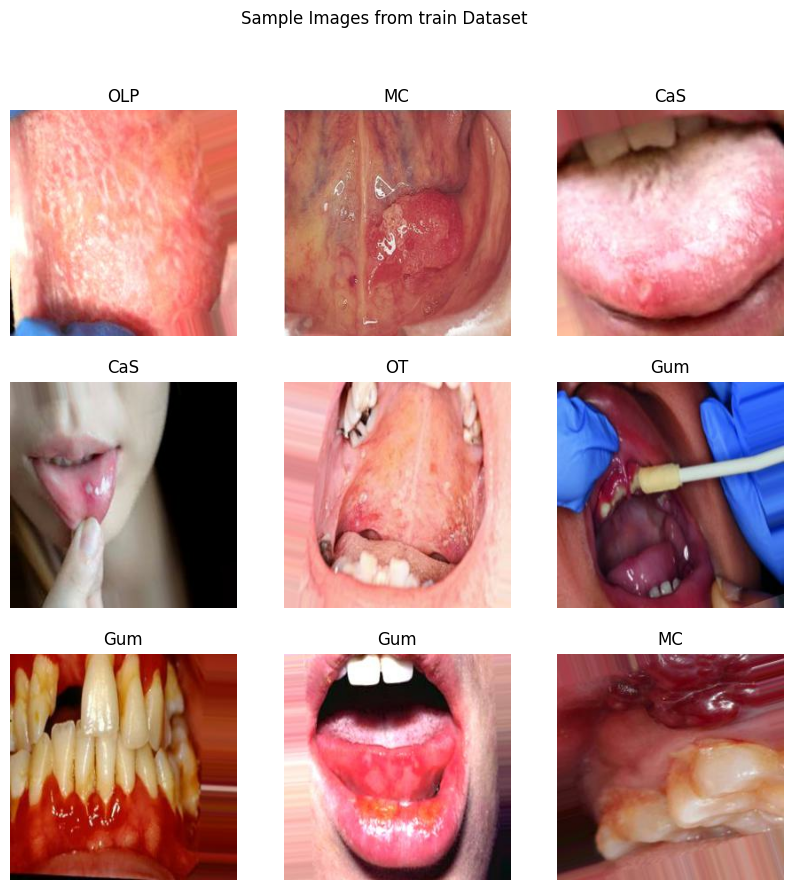

In [7]:
display_sample_images(train_dataset,"train")

# Utils

In [8]:
augmentation_layer = Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    tf.keras.layers.RandomContrast(factor=0.2),
])

In [26]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                        patience=4, min_lr=1e-6, verbose=1)

In [10]:
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        class_counts[class_name] += 1

print("Class Counts:", class_counts)

Class Counts: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}


In [11]:
counts = np.array([class_counts[class_name] for class_name in class_names])

class_weights = compute_class_weight('balanced', classes=np.arange(len(class_names)), y=np.repeat(np.arange(len(class_names)), counts))

class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [12]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [35]:
def show_results(history):
    metrics = pd.DataFrame(history.history)
    metrics[['loss', 'val_loss']].plot()
    metrics[['accuracy', 'val_accuracy']].plot()
    evalu = model
    scores = evalu.evaluate(test_dataset)
#     show_confusion_matrix()

In [14]:
def show_confusion_matrix():

    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = []
    for images, labels in test_dataset:
        true_classes.extend(labels.numpy())

    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Res-Net 50

In [15]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
with strategy.scope():
    
    inputs = base_model.input
    augmented_inputs = augmentation_layer(inputs)

    x = base_model(augmented_inputs, training=False) 
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )


In [19]:
history = model.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr],
    )

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.3600 - loss: 2.7845 - val_accuracy: 0.6304 - val_loss: 1.0413 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.6299 - loss: 0.9525 - val_accuracy: 0.7160 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.7187 - loss: 0.7649 - val_accuracy: 0.7257 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.7756 - loss: 0.6381 - val_accuracy: 0.8230 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.8052 - loss: 0.5513 - val_accuracy: 0.8482 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.8198 - loss: 0.4781 - val_accuracy: 0.8366 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.8304 - l

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9895 - loss: 0.0426


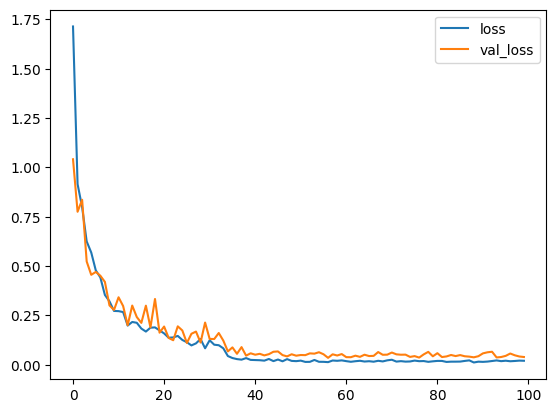

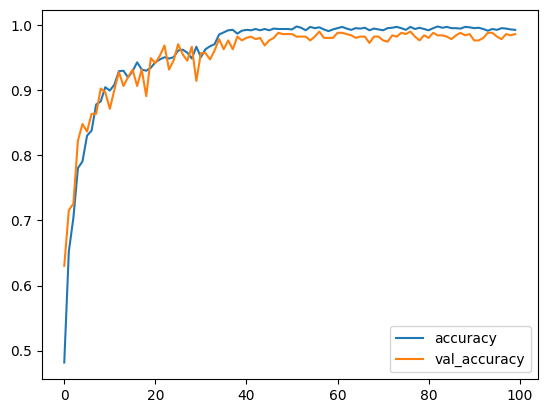

In [24]:
show_results(history)

# VGG - 16

In [30]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
with strategy.scope():
    
    inputs = base_model.input
    augmented_inputs = augmentation_layer(inputs)

    x = base_model(augmented_inputs, training=False) 
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )


In [32]:
# Sorry I forgot to change var name and this caused an error but val_accuracy is good 
model = model.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr],
    )

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.3524 - loss: 4.1194 - val_accuracy: 0.6712 - val_loss: 1.0254 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.6389 - loss: 1.0500 - val_accuracy: 0.7451 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7020 - loss: 0.8158 - val_accuracy: 0.7938 - val_loss: 0.5657 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.7547 - loss: 0.6766 - val_accuracy: 0.8093 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.7966 - loss: 0.5748 - val_accuracy: 0.8444 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.7933 - loss: 0.5543 - val_accuracy: 0.8502 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.8247 - l

AttributeError: 'History' object has no attribute 'evaluate'

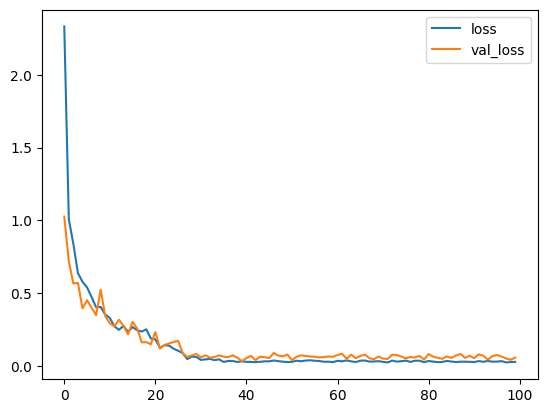

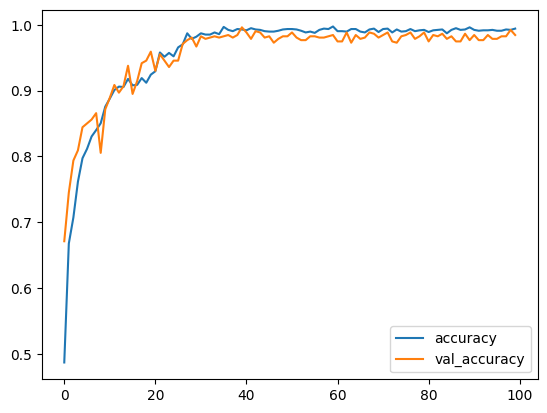

In [36]:
# Sorry I forgot to change var name and this caused an error but val_accuracy is good 
show_results(model)